In [1]:
Pkg.checkout("LowRankModels")
using LowRankModels, DataFrames, StatsBase, PyPlot
import LowRankModels: evaluate, grad

INFO: Checking out LowRankModels master...
INFO: Pulling LowRankModels latest master...
INFO: No packages to install, update or remove


In [2]:
#helper functions

evaluate(loss::Loss, X::Array{Float64,2}, w, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w, y) = X'*grad(loss, X*w, y)

function prox_grad(loss::Loss, reg::Regularizer, X, y;
                  maxiters::Int = 10, stepsize::Number = 1., 
                  ch::ConvergenceHistory = ConvergenceHistory("proxgrad"))
    w = zeros(size(X,2))
    for t=1:maxiters
        t0 = time()
        # gradient step
        g = grad(loss, X, w, y)
        w = w - stepsize*g
        # prox step
        w = prox(reg, w, stepsize)
        # record objective value
        update_ch!(ch, time() - t0, obj = evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w
end


function bool_convert(x::Array{Float64,1})
    len = length(x)
    y = Array{Bool}(len)
    for i in 1:len
        if x[i] == 1
            y[i] = true
        else 
            y[i] = false
            end
    end
    return y
end
    


grad (generic function with 18 methods)

# Model Methods

In [4]:
type Model
    target :: Symbol
    features :: Array{Symbol,1}
    #loss :: Any
    P :: Any
    loss::Loss
    reg::Regularizer
end

function get_X(model, data)
    t = model.target
    f = model.features
    X = zeros(size(data,1), length(f) - 1)
    index = 1
    for col in f
       if col != t
            X[:,index] = data[col]
            index += 1
       end
    end
    return X
end 

function get_y(model, data)
    t = model.target
    y = Array{Float64}(data[t])
    return y 
end 

function get_w(model,data)
    X = get_X(model,data) 
    y = get_y(model,data)
    L = model.loss
    R = model.reg
    if model.P == Boolean
        y = bool_convert(y)
    end
    w = prox_grad(L, R, X, y;  stepsize=1/(2*maximum(svdfact(X)[:S])^2), maxiters=50)
    return w
end

function avg_w(model,data
    ;resample_num = 1000)
    w_bs = 0
    n = size(data,1)
    for i in 1:resample_num
        #randomly samples from training set
        train_sample = data[sample(1:n,round(Int,.2*n)), :] 
        #incrememts bootstrap parameter by parameter of new sample
        w_bs = w_bs + get_w(model,data)
    end
    #finds average parameter among trials
    w_bs = w_bs / resample_num
    return w_bs
end 

function predict(model,train,test)
    w = get_w(model,train)
    X = get_X(model,test)
    #will be a function
    prediction = model.P(X,w)
    return prediction
end

predict (generic function with 1 method)

### Prediction Space to Output Space Functions

In [5]:
function Boolean(X,w)
    val = sign(X*w)
    return val
end

function Real(X,w)
    val = X*w
    return val
end

function PosReal(X,w)
    val = max(X*w,0)
    return val
end

function Integer(X,w)
    val = round(X*w)
    return val
end

function PosInteger(X,w)
    val = max(round(X*w),0)
    return val
end


PosInteger (generic function with 1 method)

## Error Measures  and Validation Functions

In [6]:
function squared_bias(model,data;num_expectation = 1000)
    w_avg = avg_w(model,data)
    t = model.target
    f = model.features
    X = get_X(model,data)
    y = get_y(model,data)
    bias2 = 0
    for i in 1:num_expectation
        index = ceil(Int,rand()*size(X,1))
        row = (X[index,:])'
        pred_value = model.P(row,w_avg)[1]
        true_value = y[index]
        
        bias2 += ((true_value - pred_value))^2
    end
    return bias2/num_expectation
end


function variance_helper(x,model,data)
    w_avg = avg_w(model,data)
    num_samples = 100
    wMat = zeros(num_samples, length(w_avg))
    for i in 1:num_samples
        sample_data = data[sample(1:size(data,1),round(Int,.5*size(data,1))), :]
        w_dataset = get_w(model,sample_data)
        wMat[i,:] = w_dataset
    end
    return mean(((wMat .- transpose(w_avg)).^2)*x.^2)
end

#function has a long run time and only works for real valued data
function variance(model,data;num_expectation = 20)
    var = 0
    X = get_X(model,data)
    for i in 1:num_expectation
        row = X[ceil(Int,rand()*size(X,1)),:]
        var += variance_helper(row,model,data)
    end
    return var / num_expectation
end

function error_est(model,data)
    return squared_bias(model,data) + variance(model,data)
end



function bool_validate(model,train,test)
    pred_val = predict(model,train,test)
    true_val = get_y(model,test)
    n = length(pred_val)
    count = 0
    for i in 1:n
        if pred_val[i] != true_val[i]
            count +=1
        end
    end
    return (count/n)
end

function mse_validate(model,train,test)
    pred_val = predict(model,train,test)
    true_val = get_y(model,test)
    err = mean((pred_val .- true_val).^2)
    return err
end



mse_validate (generic function with 1 method)

# Data Cleaning/Manipulation Functions

In [7]:
#Pre Condition: missing values have been removed since all entries will become column names 
function one_hot_encode(data::DataFrame, column_name::Symbol)
    n = size(data,1) #length of columns 
    binary_data = DataFrame() #new dataframe to store cleaned data
    old_row = data[column_name]
    #creates new columns out of entries of old column
    for new_col in unique(data[column_name])
        binary_data[Symbol(new_col)] = -1*ones(n)
    end
    #fills in binary values {1,-1} for each row
    for i in 1:n
        binary_data[i,Symbol(old_row[i])] = 1.0
    end
    return binary_data
end 

#Pre Condition: data is heart attack data from SPARCS dataset
function remove_missing_data(data::DataFrame)
    cdata = copy(data)
    #Length of Stay
    cdata = cdata[cdata[:Length_of_Stay] .!= "120 +",:]
    cdata[:Length_of_Stay] = float(cdata[:Length_of_Stay])
    #Payment_Typology
    cdata = cdata[cdata[:Payment_Typology_1] .!= "Miscellaneous/Other",:]
    cdata = cdata[cdata[:Payment_Typology_1] .!= "Unknown",:]
    #Patient_Dispostion 
    cdata = cdata[cdata[:Patient_Disposition] .!= "Another Type Not Listed",:]
    #Type of Admission
    cdata = cdata[cdata[:Type_of_Admission] .!= "Not Available",:]
    #Race
    cdata = cdata[cdata[:Race] .!= "Unknown",:]
    #Total Charges
    n = size(cdata,1)
    for i in 1:n
        if cdata[:Total_Charges][i][2:end] == "" #impute better
            val = "0"
        else 
            val = cdata[:Total_Charges][i][2:end]
        end
            cdata[:Total_Charges][i] = val
    end
    cdata[:Total_Charges] = float(cdata[:Total_Charges])
    return cdata
end

#Pre_Condition: data is heart_attack data from SPARCS dataset
function clean(data::DataFrame)
    temp = remove_missing_data(data)
    clean_data = DataFrame()
    categorical_col = [:Health_Service_Area,:Age_Group,:Hospital_County,
                    :Patient_Disposition,:Gender,:Race,
                    :Type_of_Admission,:Payment_Typology_1]
    for col in categorical_col
        clean_data = hcat(clean_data,one_hot_encode(temp,col))
    end
    delete!(clean_data,:F)
    clean_data[:Length_of_Stay] = temp[:Length_of_Stay]
    clean_data[:Total_Charges] = temp[:Total_Charges]
    clean_data[:APR_Severity_of_Illness_Code] = temp[:APR_Severity_of_Illness_Code]
    clean_data[:offset] = ones(size(clean_data,1))
    return clean_data
end


#helper function for split_data
function build_subset(index,data)
    subset = similar(data,length(index))
    for i in 1:length(index)
        subset[i,:] = data[index[i],:]
    end
    return subset
end 

#splits dataset into train and test sets
#splits data based on the discharge identifier column :x (integer)
#split_raio = ratio of training set size to entire dataset size
function split_data(data_set;split_ratio = .8)
    n = size(data_set,1)
    split = Int(round(split_ratio*n))
    rand_index = shuffle([i for i in 1:n])
    train_index = rand_index[1:split]
    test_index = rand_index[split + 1:n]
    train = build_subset(train_index,data_set)
    test = build_subset(test_index,data_set)
    return(train,test)
end 


split_data (generic function with 1 method)

# Testing Space

## Depression Analysis

In [47]:
depression = readtable("depression_clean.csv")
train,test = split_data(depression)


(22873×102 DataFrames.DataFrame
│ Row   │ Western_NY │ Finger_Lakes │ Central_NY │ Southern_Tier │
├───────┼────────────┼──────────────┼────────────┼───────────────┤
│ 1     │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 2     │ -1.0       │ -1.0         │ 1.0        │ -1.0          │
│ 3     │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 4     │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 5     │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 6     │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 7     │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 8     │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 9     │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 10    │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
│ 11    │ -1.0       │ -1.0         │ -1.0       │ -1.0          │
⋮
│ 22862 │ -1.0       │ -1.0         │ 1.0        │ -1.0          │
│ 22863 │ -1.0       │ -1.0 

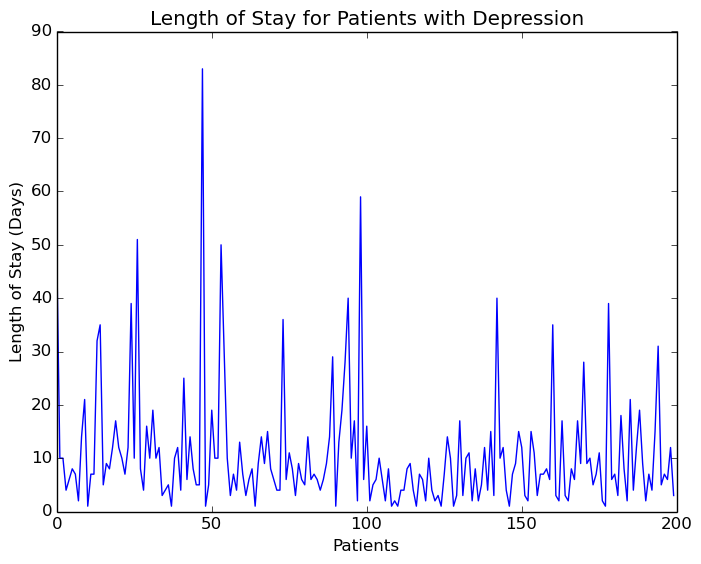

PyObject <matplotlib.text.Text object at 0x7f5647a9a690>

In [165]:
#data visualization
plot(test[:Length_of_Stay][1:200])
xlabel("Patients")
ylabel("Length of Stay (Days)")
title("Length of Stay for Patients with Depression")

In [49]:
#model fitting
target = :Length_of_Stay
f2 = [:Western_NY,:Finger_Lakes,:Central_NY,:Southern_Tier,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island,
    :x70_or_Older,:x30_to_49,:x50_to_69,:x18_to_29,:x0_to_17,
    :M,
    :White,:Other_Race,:Black_African_American,
    :Elective,:Emergency,:Urgent,:Trauma,
    :Length_of_Stay,
    :APR_Severity_of_Illness_Code,
    :offset]

m4 = Model(target,f2,PosInteger, QuadLoss(),ZeroReg())
m5 = Model(target,f2,PosInteger, L1Loss(),ZeroReg())
qloss = QuantileLoss(quantile = .85)
mq = Model(target,f2,PosInteger, qloss,ZeroReg())

24-element Array{Symbol,1}:
 :Western_NY                  
 :Finger_Lakes                
 :Central_NY                  
 :Southern_Tier               
 :Capital_Adiron              
 :Hudson_Valley               
 :New_York_City               
 :Long_Island                 
 :x70_or_Older                
 :x30_to_49                   
 :x50_to_69                   
 :x18_to_29                   
 :x0_to_17                    
 :M                           
 :White                       
 :Other_Race                  
 :Black_African_American      
 :Elective                    
 :Emergency                   
 :Urgent                      
 :Trauma                      
 :Length_of_Stay              
 :APR_Severity_of_Illness_Code
 :offset                      

In [90]:
#model validation (MSE)
@show mse_validate(m4,train,test)
@show mse_validate(m5,train,test)
e = []
for q in 1:100
    qloss = QuantileLoss(quantile = q/100)
    mq = Model(target,f2,PosInteger, qloss,ZeroReg())
    push!(e,mse_validate(mq,train,test))
end
findmin(e)

mse_validate(m4,train,test) = 127.15809723679608
mse_validate(m5,train,test) = 143.52920601608955
mse_validate(mq,train,test) = 137.20356768100734


137.20356768100734

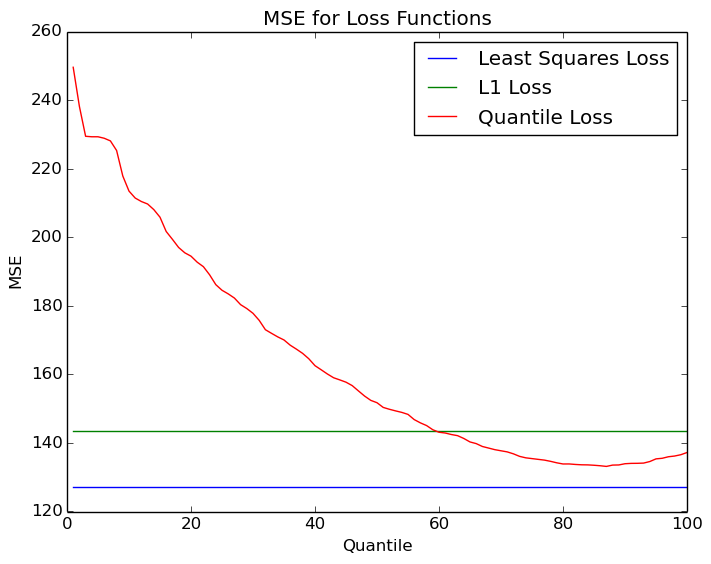

PyObject <matplotlib.legend.Legend object at 0x7f56480bc390>

In [86]:
#visualization of model validation (MSE)
ls = []
l1 = []
for i in 1:100
    push!(ls,127.158)
    push!(l1,143.529)
end

plot(1:100,ls, label = "Least Squares Loss")
plot(1:100,l1, label = "L1 Loss")
plot(1:100,e, label = "Quantile Loss")
xlabel("Quantile")
ylabel("MSE")
title("MSE for Loss Functions")
legend()

In [161]:
#new error measure

function weighted_error(model,train,test; weight = 0.5)
    pred_val = predict(model,train,test)
    true_val = get_y(model,test)
    n = length(pred_val)
    diff = true_val .- pred_val
    for i in 1:n
        if diff[i] < 0
            diff[i] = (weight*diff[i])^2
        else 
                diff[i] = diff[i]^2
        end
    end
    return mean(diff)
end
   

@show weighted_error(m4,train,test)
@show weighted_error(m5,train,test)
@show weighted_error(mq,train,test)
we = []
for q in 1:100
    qloss = QuantileLoss(quantile = q/100)
    mq = Model(target,f2,PosInteger, qloss,ZeroReg())
    push!(we,weighted_error(mq,train,test))
end
findmin(we)

(106.37893494228751,100)

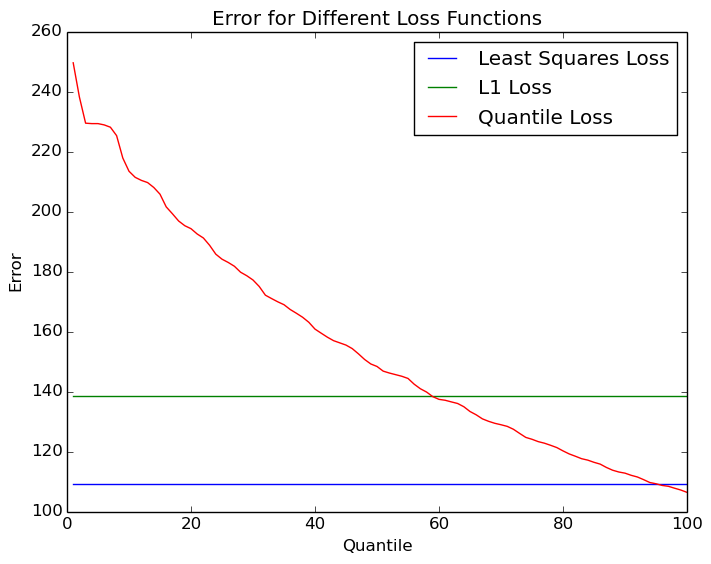

PyObject <matplotlib.legend.Legend object at 0x7f5647b0c210>

In [164]:
#visualization of new error measure
wls = []
wl1 = []
for i in 1:100
    push!(wls,109.0938265127667)
    push!(wl1,138.52986183980414)
end

plot(1:100,wls, label = "Least Squares Loss")
plot(1:100,wl1, label = "L1 Loss")
plot(1:100,we, label = "Quantile Loss")
xlabel("Quantile")
ylabel("Error")
title("Error for Different Loss Functions")
legend()

## Hip Replacement Analysis

In [22]:
HR = readtable("HR_clean.csv")
train,test = split_data(HR)


(21962×103 DataFrames.DataFrame
│ Row   │ Western_NY │ Finger_Lakes │ Southern_Tier │ Central_NY │
├───────┼────────────┼──────────────┼───────────────┼────────────┤
│ 1     │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 2     │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 3     │ -1.0       │ -1.0         │ -1.0          │ 1.0        │
│ 4     │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 5     │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 6     │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 7     │ -1.0       │ -1.0         │ -1.0          │ 1.0        │
│ 8     │ -1.0       │ 1.0          │ -1.0          │ -1.0       │
│ 9     │ 1.0        │ -1.0         │ -1.0          │ -1.0       │
│ 10    │ 1.0        │ -1.0         │ -1.0          │ -1.0       │
│ 11    │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
⋮
│ 21951 │ -1.0       │ -1.0         │ -1.0          │ 1.0        │
│ 21952 │ -1.0       │ 1.0  

In [24]:
#model fitting
target = :Total_Charges
f3 = [:Western_NY,:Finger_Lakes,:Southern_Tier,:Central_NY,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island,
    :x70_or_Older,:x50_to_69,:x30_to_49,:x18_to_29,:x0_to_17,
    :White,:Other_Race,:Black_African_American,
    :Emergency,:Elective,:Urgent,:Trauma,:Newborn,
    :Total_Charges,
    :APR_Severity_of_Illness_Code,
    :offset]
f4 = [:Western_NY,:Finger_Lakes,:Southern_Tier,:Central_NY,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island,
    :x70_or_Older,:x50_to_69,:x30_to_49,:x18_to_29,:x0_to_17,
    :Allegany,:Cattaraugus,:Chautauqua,:Erie,:Genesee,:Niagara,:Orleans,:Wyoming,:Chemung,:Livingston,:Monroe,:Ontario,:Schuyler,:Steuben,:Wayne,:Broome,:Cayuga,:Chenango,:Cortland,:Jefferson,:Lewis,:Madison,:Oneida,:Onondaga,:Oswego,:St_Lawrence,:Tompkins,:Albany,:Clinton,:Columbia,:Franklin,:Fulton,:Montgomery,:Otsego,:Rensselaer,:Saratoga,:Schenectady,:Warren,:Dutchess,:Orange,:Putnam,:Rockland,:Sullivan,:Ulster,:Westchester,:Bronx,:Kings,:Manhattan,:Queens,:Richmond,:Suffolk,:Nassau,
    :M,
    :White,:Other_Race,:Black_African_American,
    :Emergency,:Elective,:Urgent,:Trauma,:Newborn,
    :Medicare,:Private_Health_Insurance,:Blue_Cross_Blue_Shield,:Medicaid,:Federal_State_Local_VA,:Self_Pay,:Department_of_Corrections,:Managed_Care_Unspecified,
    :Total_Charges,
    :APR_Severity_of_Illness_Code,
    :offset]

m6 = Model(target,f3,PosReal, QuadLoss(),ZeroReg())
m7 = Model(target,f4,PosReal, QuadLoss(),ZeroReg())

85-element Array{Symbol,1}:
 :Western_NY                  
 :Finger_Lakes                
 :Southern_Tier               
 :Central_NY                  
 :Capital_Adiron              
 :Hudson_Valley               
 :New_York_City               
 :Long_Island                 
 :x70_or_Older                
 :x50_to_69                   
 :x30_to_49                   
 :x18_to_29                   
 :x0_to_17                    
 ⋮                            
 :Newborn                     
 :Medicare                    
 :Private_Health_Insurance    
 :Blue_Cross_Blue_Shield      
 :Medicaid                    
 :Federal_State_Local_VA      
 :Self_Pay                    
 :Department_of_Corrections   
 :Managed_Care_Unspecified    
 :Total_Charges               
 :APR_Severity_of_Illness_Code
 :offset                      

In [46]:
#model validation (MSE)
@show mse_validate(m6,train,test)
@show mse_validate(m7,train,test)

mse_validate(m6,train,test) = 4.9898511351157695e8
mse_validate(m7,train,test) = 5.599733105814097e8
mse_validate(m6,train,train) = 5.367030394498036e8
mse_validate(m7,train,train) = 5.974000352806507e8


5.974000352806507e8

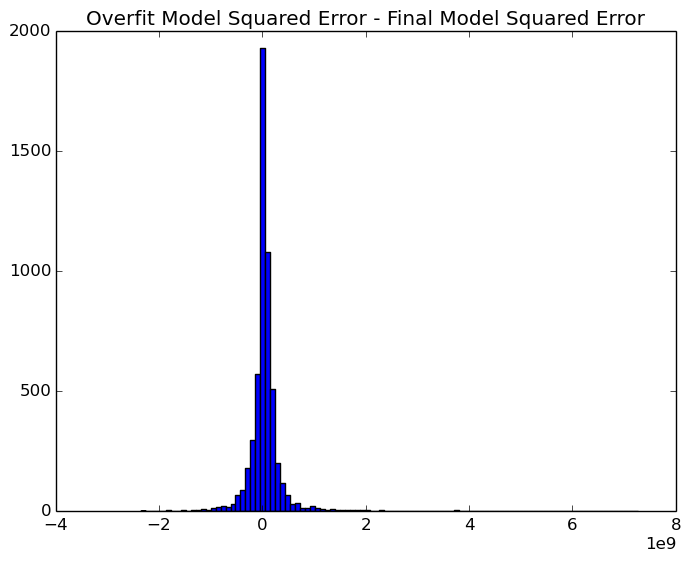

PyObject <matplotlib.text.Text object at 0x7f8d09e17890>

In [53]:
#error visualization
true_val = test[:Total_Charges]
overfit_predict = predict(m7,train,test)
model_predict = predict(m6,train,test)
overfit_abs_error = (true_val - overfit_predict).^2
predict_abs_error = (true_val - model_predict).^2
diff = overfit_abs_error - predict_abs_error
new_diff = []
for i in diff
    if abs(i) < 2*10^9
        push!(new_diff,i)
    end
end
plt[:hist](diff, 100)
title("Overfit Model Squared Error - Final Model Squared Error")


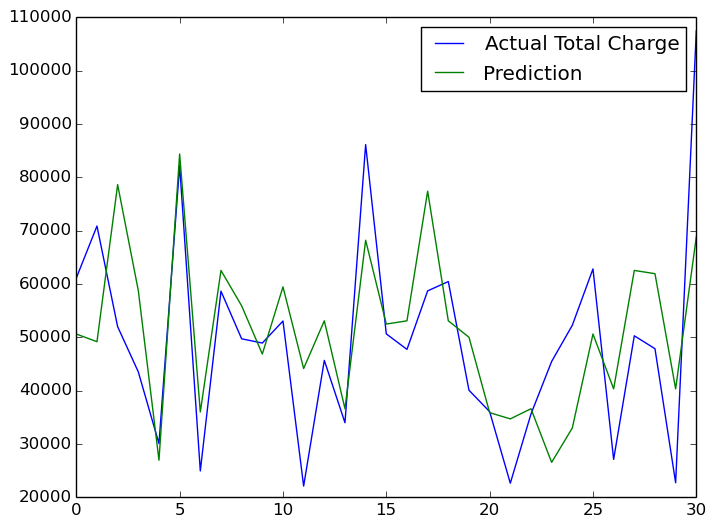

PyObject <matplotlib.legend.Legend object at 0x7f8d0a6c5c90>

In [49]:
#prediction visualization 
plot(test[:Total_Charges][200:230], label = "Actual Total Charge")
plot(predict(m6,train,test)[200:230], label = "Prediction")
legend()

## Heart Attack Analysis 

In [10]:
heart_attack = readtable("multi_heart_attack_clean.csv")
train,test = split_data(heart_attack)


(846×77 DataFrames.DataFrame
│ Row │ Western_NY │ Finger_Lakes │ Southern_Tier │ Central_NY │
├─────┼────────────┼──────────────┼───────────────┼────────────┤
│ 1   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 2   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 3   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 4   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 5   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 6   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 7   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 8   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 9   │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 10  │ -1.0       │ -1.0         │ -1.0          │ 1.0        │
│ 11  │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
⋮
│ 835 │ -1.0       │ -1.0         │ -1.0          │ -1.0       │
│ 836 │ -1.0       │ -1.0         │ -1.0          │ -1.0   

In [11]:
#model fitting
target = :outcome
f = [:Western_NY,:Finger_Lakes,:Southern_Tier,:Central_NY,:Capital_Adiron,:Hudson_Valley,:New_York_City,:Long_Island,
    :x70_or_Older,:x18_to_29,:x50_to_69,:x30_to_49,:x0_to_17,
    :outcome,
    :M,
    :White,:Black_African_American,:Other_Race,
    :Emergency,:Urgent,:Elective,:Trauma,:Medicare,
    :Self_Pay,:Blue_Cross_Blue_Shield,:Medicaid,:Private_Health_Insurance,:Managed_Care_Unspecified,:Federal_State_Local_VA,:Department_of_Corrections,
    :APR_Severity_of_Illness_Code,
    :offset]
loss = MultinomialLoss(5) 
m8 = Model(target,f,Boolean, loss,ZeroReg())
include("proxgrad.jl")


32-element Array{Symbol,1}:
 :Western_NY                  
 :Finger_Lakes                
 :Southern_Tier               
 :Central_NY                  
 :Capital_Adiron              
 :Hudson_Valley               
 :New_York_City               
 :Long_Island                 
 :x70_or_Older                
 :x18_to_29                   
 :x50_to_69                   
 :x30_to_49                   
 :x0_to_17                    
 ⋮                            
 :Elective                    
 :Trauma                      
 :Medicare                    
 :Self_Pay                    
 :Blue_Cross_Blue_Shield      
 :Medicaid                    
 :Private_Health_Insurance    
 :Managed_Care_Unspecified    
 :Federal_State_Local_VA      
 :Department_of_Corrections   
 :APR_Severity_of_Illness_Code
 :offset                      

In [34]:
#Repeated random sub-sampling cross validation for multinomial classification

#learning probabilities
cv =  []
for k in 1:50
    train1,test1 = split_data(train)
    X = get_X(m8,train1)
    y = Array{Int}(get_y(m8,train1))
    n = length(y)
    scale!(loss, 1/n)
    w_mnl = proxgrad(loss, ZeroReg(), X, y, stepsize=1, maxiters=200)
    prediction = get_X(m8,test1)*w_mnl
    n = size(prediction,1)
    final_prediction = zeros(n)
    for i in 1:n
        final_prediction[i] = findmax(prediction[i,:])[2]
    end
    true_val = Array{Int}(get_y(m8,test1))
    err = 0
    for i in 1:n
        if final_prediction[i] != true_val[i]
            err += 1
        end
    end
    err = err / n
    push!(cv,err)
end
@show mean(cv)

#one v all
cv2 =  []
loss = OvALoss(5, bin_loss = LogisticLoss())
for k in 1:50
    train1,test1 = split_data(train)
    X = get_X(m8,train1)
    y = Array{Int}(get_y(m8,train1))
    n = length(y)
    scale!(loss, 1/n)
    w_mnl = proxgrad(loss, ZeroReg(), X, y, stepsize=1, maxiters=200)
    prediction = get_X(m8,test1)*w_mnl
    n = size(prediction,1)
    final_prediction = zeros(n)
    for i in 1:n
        final_prediction[i] = findmax(prediction[i,:])[2]
    end
    true_val = Array{Int}(get_y(m8,test1))
    err = 0
    for i in 1:n
        if final_prediction[i] != true_val[i]
            err += 1
        end
    end
    err = err / n
    push!(cv2,err)
end
mean(cv2)

In [35]:
#validation 
X = get_X(m8,train)
y = Array{Int}(get_y(m8,train))
n = length(y)
scale!(loss, 1/n)
w_mnl = proxgrad(loss, ZeroReg(), X, y, stepsize=1, maxiters=200)
prediction = get_X(m8,test)*w_mnl
n = size(prediction,1)
final_prediction = zeros(n)
for i in 1:n
    final_prediction[i] = findmax(prediction[i,:])[2]
end
true_val = Array{Int}(get_y(m8,test))
err = 0
err_by_category = zeros(5)
num_by_category = zeros(5)
for i in 1:n
    num_by_category[true_val[i]] += 1
    if final_prediction[i] != true_val[i]
        err += 1
        err_by_category[true_val[i]] += 1
    end
end
err = err / n
err_results_by = err_by_category ./ num_by_category

0.33962264150943394